In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from ebc.sequential.non_iterative import SensitivityBasedIS
from ebc.sequential.iterative_with_convexification import SensitivityBasedFW
from ebc.sequential.iterative_no_convexification import SparseVI, GIGA, IHT
from ebc.parallel.parallel_iterative_with_convexification import ParallelSensitivityBasedFW
from ebc.gaussian import fisher_norm_under_true_gaussian_posterior, gaussian_multivariate_log_likelihood, gaussian_KL

In [2]:
# Generate Data
d = 20
N = 1000

np.random.seed(123)

# Theta as in sparse_vi
theta = np.random.multivariate_normal(mean = np.zeros(d), cov = np.identity(d))

# x as in sparse_vi
x = np.random.multivariate_normal(mean = theta, cov = np.identity(d), size = N)

# Parameters
sigma_0 = np.identity(d)
sigma = np.identity(d)
mu_0 = np.zeros(d).reshape(-1, 1)

# Full Gaussian posterior
sigma_full = np.linalg.inv(np.linalg.inv(sigma_0) + N * np.linalg.inv(sigma))
mu_full =  sigma_full @ (np.linalg.inv(sigma_0) @ mu_0 + np.linalg.inv(sigma) @ np.sum(x, axis = 0).reshape(-1, 1))        

In [3]:
print(f"x: {x.shape}")
print(f"mu: {mu_0.shape}")

x: (1000, 20)
mu: (20, 1)


In [4]:
def log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return np.diag(gaussian_multivariate_log_likelihood(X.T, mu, sigma)).reshape(-1, 1)

# https://stats.stackexchange.com/questions/90134/gradient-of-multivariate-gaussian-log-likelihood
def grad_log_likelihood(params, X, y, weights):
    mu = params[:d].reshape(-1, 1)
    sigma = np.diag(params[d:].reshape(-1, 1)[:, 0])
    return (-np.linalg.inv(sigma) @ (X.T - mu)).reshape(-1, X.shape[1])

def log_posterior(params, X, y, weights):
    return weights.T @ log_likelihood(params, X, y, weights)

In [5]:
def log_posterior(params, X, y, weights):
        return np.sum(log_likelihood(params, X, y, weights))

In [6]:
likelihood_gram_matrix = fisher_norm_under_true_gaussian_posterior(x.T, x.T, mu_0, N)

In [7]:
from sklearn.decomposition import PCA

def plot_points(points, indices, w):
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    plt.scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    plt.scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    plt.title("Points")
    plt.ylabel("PCA2")
    plt.xlabel("PCA1")
    plt.grid()
    plt.legend()
    
def plot_results(fkl, bkl, points, indices, w):
    fig, ax = plt.subplots(1, 3, figsize = (20, 5))
    ax[0].plot(fkl)
    ax[0].set_title("FKL")
    ax[0].set_ylabel("FKL")
    ax[0].set_xlabel("Coreset Size")
    ax[0].grid()
    
    ax[1].plot(fkl)
    ax[1].set_title("BKL")
    ax[1].set_ylabel("BKL")
    ax[1].set_xlabel("Coreset Size")
    ax[1].grid()
    
    pca = PCA(n_components = 2)
    vecs = pca.fit_transform(points)
    ax[2].scatter(vecs[indices, 0], vecs[indices, 1], 
                  s = w.flatten()[indices] * 50, alpha = 0.5)
    vecs = np.delete(vecs, indices, axis = 0)
    ax[2].scatter(vecs[:, 0], vecs[:, 1], alpha = 0.5, label = "NOT in coreset")
    ax[2].set_title("Points")
    ax[2].set_ylabel("PCA2")
    ax[2].set_xlabel("PCA1")
    ax[2].grid()
    ax[2].legend()
    
    #for ind in indices:
    #    ax[2].annotate(round(w.flatten()[ind]), (vecs[ind, 0], vecs[ind, 1]))

---

---

In [8]:
sbis = SensitivityBasedIS(x)

na = {"log_likelihood": log_likelihood,
  "log_likelihood_start_value": np.ones(2 * d),
  "S": 150,
  "log_likelihood_gradient": grad_log_likelihood,
  "approx": "Laplace",
  "MCMC_subs_size": 100}

w, I = sbis.run(k = 20, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

print('===')

w, I = sbis.run(k = 200, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

print('===')

w, I = sbis.run(k = 500, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

print('===')

step1 10.29118800163269
step2 1.621246337890625e-05
step4 0.0006108283996582031
===
step1 9.711379051208496
step2 8.821487426757812e-06
step4 0.0005528926849365234
===
step1 9.483436107635498
step2 8.821487426757812e-06
step4 0.00044274330139160156
===


In [7]:
sbfw = SensitivityBasedFW(x)

na = {"log_likelihood": log_likelihood,
  "log_likelihood_start_value": np.ones(2 * d),
  "S": 150,
  "log_likelihood_gradient": grad_log_likelihood,
  "approx": "Laplace",
  "MCMC_subs_size": 100}

w, I = sbfw.run(k = 20, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

print('===')

w, I = sbfw.run(k = 200, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

print('===')

w, I = sbfw.run(k = 500, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)

print('===')

step1 9.673496961593628
s2 0.007975339889526367
s3 0.000164031982421875
s4 0.013739347457885742
===
step1 9.896965265274048
s2 0.10611939430236816
s3 0.003424406051635742
s4 0.2059619426727295
===
step1 9.864297866821289
s2 0.23502659797668457
s3 0.0077898502349853516
s4 0.442737340927124
===


In [7]:
svi = SparseVI(x)
na = {"log_likelihood": log_likelihood,
      "log_posterior": log_posterior,
      "log_posterior_start_value": np.ones(2 * d),
      "S": 150,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "MCMC"}

w, I = svi.run(k = 20, likelihood_gram_matrix = likelihood_gram_matrix, 
               norm_attributes = na, T = 100, gamma_func = lambda x : 1 / x)

print('===')

w, I = svi.run(k = 200, likelihood_gram_matrix = likelihood_gram_matrix, 
               norm_attributes = na, T = 100, gamma_func = lambda x : 1 / x)

print('===')

w, I = svi.run(k = 500, likelihood_gram_matrix = likelihood_gram_matrix, 
               norm_attributes = na, T = 100, gamma_func = lambda x : 1 / x)

print('===')

s1 3.814697265625e-06
s2 0.005140542984008789
s3 0.0003466606140136719
s4 0.34872913360595703
===
s1 7.152557373046875e-07
s2 0.02663564682006836
s3 0.002057313919067383
s4 3.0166895389556885
===
s1 0.0
s2 0.06612658500671387
s3 0.005747795104980469
s4 7.762170791625977
===


In [7]:
giga = GIGA(x)

na = {"log_likelihood": log_likelihood,
  "log_likelihood_start_value": np.ones(2 * d),
  "S": 150,
  "log_likelihood_gradient": grad_log_likelihood,
  "approx": "Laplace",
  "MCMC_subs_size": 100}

w, I = giga.run(k = 20, likelihood_vectors = None, norm = "2", norm_attributes = na)

print('===')

w, I = giga.run(k = 200, likelihood_vectors = None, norm = "2", norm_attributes = na)

print('===')

w, I = giga.run(k = 500, likelihood_vectors = None, norm = "2", norm_attributes = na)

print('===')

s1 9.744696855545044
s2 0.023221969604492188
s3 0.0008225440979003906
s4 0.00639796257019043
===
s1 9.528355121612549
s2 0.232161283493042
s3 0.008537530899047852
s4 0.061745643615722656
===
s1 9.632551193237305
s2 0.5769641399383545
s3 0.02127385139465332
s4 0.15732550621032715
===


In [7]:
iht = IHT(x)

na = {"log_likelihood": log_likelihood,
  "log_likelihood_start_value": np.ones(2 * d),
  "S": 150,
  "log_likelihood_gradient": grad_log_likelihood,
  "approx": "Laplace",
  "MCMC_subs_size": 100}

w, I = iht.run(k = 20, likelihood_vectors = None, norm = "2", norm_attributes = na)

print('===')

w, I = iht.run(k = 200, likelihood_vectors = None, norm = "2", norm_attributes = na)

print('===')

w, I = iht.run(k = 500, likelihood_vectors = None, norm = "2", norm_attributes = na)

print('===')

s1 9.879639863967896
s2 0.20624256134033203
s3 0.2554507255554199
s4 0.3558673858642578
===
s1 9.679489135742188
s2 0.20745277404785156
s3 0.33858799934387207
s4 0.3341825008392334
===
s1 9.948122024536133
s2 0.20511436462402344
s3 0.4359571933746338
s4 0.30448246002197266
===


---

In [19]:
fkl = np.zeros((10, 5))
bkl = np.zeros((10, 5))

na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 500,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "MCMC",
      "MCMC_subs_size": 500,
      "log_posterior": log_posterior,
      "log_posterior_start_value": np.ones(2 * d)}
j = 0
for i in range(10, 110, 10):
    sbis = SensitivityBasedIS(x)
    sbfw = SensitivityBasedFW(x)
    giga = GIGA(x)
    svi = SparseVI(x)
    iht = IHT(x)
    
    w1, I1 = sbis.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    w2, I2 = sbfw.run(k = i, likelihood_gram_matrix = None, norm = "2", norm_attributes = na)
    w3, I3 = giga.run(k = i, likelihood_vectors = None, norm = "2", norm_attributes = na)
    w4, I4 = svi.run(k = i, likelihood_gram_matrix = None, 
                     norm_attributes = na, T = 100, gamma_func = lambda x : 1 / x)
    w5, I5 = iht.run(k = i, likelihood_vectors = None, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w1)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w1)

    fkl[j, 0] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[j, 0] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w2)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w2)

    fkl[j, 1] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[j, 1] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w3)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w3)

    fkl[j, 2] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[j, 2] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w4)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w4)

    fkl[j, 3] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[j, 3] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w5)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w5)

    fkl[j, 4] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[j, 4] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    j += 1

s1 2.378671169281006
s2 0.5502340793609619
s3 0.28688812255859375
s4 0.6701991558074951
s1 2.4279706478118896
s2 0.5396373271942139
s3 0.2794525623321533
s4 0.6331851482391357
s1 2.3189806938171387
s2 0.5476763248443604
s3 0.2972605228424072
s4 0.6423418521881104
s1 2.6144537925720215
s2 0.5856847763061523
s3 0.31437063217163086
s4 0.73116135597229
s1 2.5113022327423096
s2 0.5510828495025635
s3 0.29801464080810547
s4 0.6611902713775635
s1 2.3970558643341064
s2 0.5408203601837158
s3 0.2991974353790283
s4 0.6190919876098633
s1 2.574859619140625
s2 0.5471203327178955
s3 0.3169245719909668
s4 0.623117208480835
s1 2.3495609760284424
s2 0.5419247150421143
s3 0.30393457412719727
s4 0.6047594547271729
s1 2.38238525390625
s2 0.5617876052856445
s3 0.3191530704498291
s4 0.6838748455047607
s1 2.9594788551330566
s2 0.5888419151306152
s3 0.35703420639038086
s4 0.7562949657440186


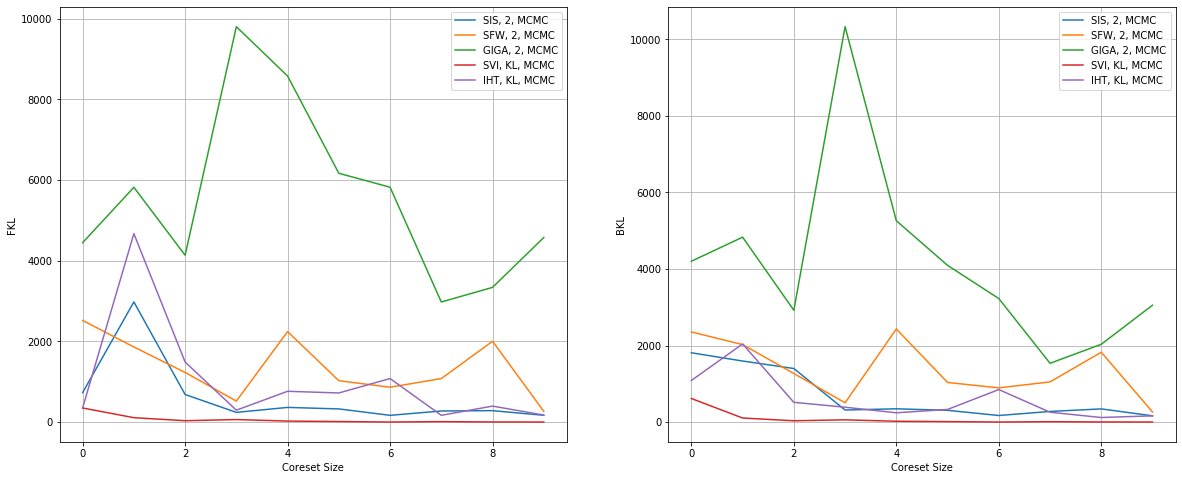

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(fkl[:, 0], label = 'SIS, 2, MCMC')
ax[0].plot(fkl[:, 1], label = 'SFW, 2, MCMC')
ax[0].plot(fkl[:, 2], label = 'GIGA, 2, MCMC')
ax[0].plot(fkl[:, 3], label = 'SVI, KL, MCMC')
ax[0].plot(fkl[:, 4], label = 'IHT, 2, MCMC')
ax[0].legend()
ax[0].set_xlabel("Coreset Size")
ax[0].set_ylabel("FKL")
ax[0].grid()

ax[1].plot(bkl[:, 0], label = 'SIS, 2, MCMC')
ax[1].plot(bkl[:, 1], label = 'SFW, 2, MCMC')
ax[1].plot(bkl[:, 2], label = 'GIGA, 2, MCMC')
ax[1].plot(bkl[:, 3], label = 'SVI, KL, MCMC')
ax[1].plot(bkl[:, 4], label = 'IHT, 2, MCMC')
ax[1].legend()
ax[1].set_xlabel("Coreset Size")
ax[1].set_ylabel("BKL")
ax[1].grid()

---

In [8]:
from ebc.approximations import random_kitchen_sinks
v = random_kitchen_sinks(x, None, 1, "Laplace", log_likelihood, 
                         np.ones(2 * d), 1000, norm = "2", MCMC_subs_size = 100)

In [11]:
fkl = np.zeros((10, 5))
bkl = np.zeros((10, 5))

na = {"log_likelihood": log_likelihood,
      "log_likelihood_start_value": np.ones(2 * d),
      "S": 500,
      "log_likelihood_gradient": grad_log_likelihood,
      "approx": "MCMC",
      "MCMC_subs_size": 500,
      "log_posterior": log_posterior,
      "log_posterior_start_value": np.ones(2 * d)}
j = 0
for i in range(10, 110, 10):
    sbis = SensitivityBasedIS(x)
    sbfw = SensitivityBasedFW(x)
    giga = GIGA(x)
    svi = SparseVI(x)
    iht = IHT(x)
    
    w1, I1 = sbis.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    w2, I2 = sbfw.run(k = i, likelihood_gram_matrix = likelihood_gram_matrix, norm = "2", norm_attributes = na)
    w3, I3 = giga.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    w4, I4 = svi.run(k = i, likelihood_gram_matrix = None, 
                     norm_attributes = na, T = 100, gamma_func = lambda x : 1 / x)
    w5, I5 = iht.run(k = i, likelihood_vectors = v, norm = "2", norm_attributes = na)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w1)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w1)

    fkl[j, 0] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[j, 0] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w2)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w2)

    fkl[j, 1] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[j, 1] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w3)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w3)

    fkl[j, 2] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[j, 2] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w4)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w4)

    fkl[j, 3] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[j, 3] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    # Calculate posterior approximation
    sigma_hat = 1 / (1 + np.sum(w5)) * np.identity(d)
    mu_hat = sigma_hat @ (mu_0 + x.T @ w5)

    fkl[j, 4] = gaussian_KL(sigma_full, sigma_hat, mu_full, mu_hat)
    bkl[j, 4] = gaussian_KL(sigma_hat, sigma_full, mu_hat, mu_full)
    
    j += 1

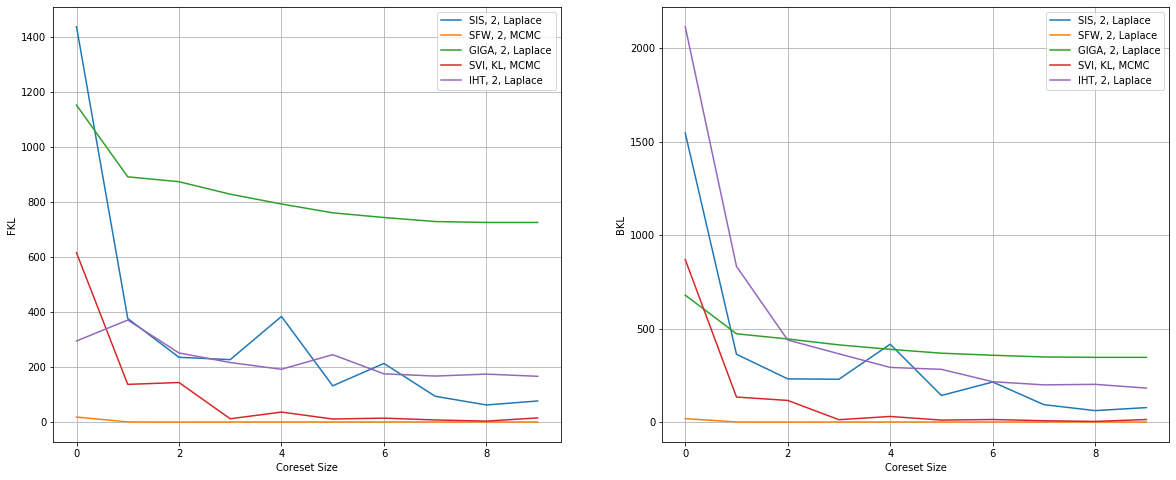

In [13]:
fig, ax = plt.subplots(1, 2, figsize = (20, 8))
ax[0].plot(fkl[:, 0], label = 'SIS, 2, Laplace')
ax[0].plot(fkl[:, 1], label = 'SFW, 2, MCMC')
ax[0].plot(fkl[:, 2], label = 'GIGA, 2, Laplace')
ax[0].plot(fkl[:, 3], label = 'SVI, KL, MCMC')
ax[0].plot(fkl[:, 4], label = 'IHT, 2, Laplace')
ax[0].legend()
ax[0].set_xlabel("Coreset Size")
ax[0].set_ylabel("FKL")
ax[0].grid()

ax[1].plot(bkl[:, 0], label = 'SIS, 2, Laplace')
ax[1].plot(bkl[:, 1], label = 'SFW, 2, Laplace')
ax[1].plot(bkl[:, 2], label = 'GIGA, 2, Laplace')
ax[1].plot(bkl[:, 3], label = 'SVI, KL, MCMC')
ax[1].plot(bkl[:, 4], label = 'IHT, 2, Laplace')
ax[1].legend()
ax[1].set_xlabel("Coreset Size")
ax[1].set_ylabel("BKL")
ax[1].grid()